# Exploratory Data Analysis

### Libraries

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

import missingno as msno
import warnings

# Significance tests
from scipy.stats import mannwhitneyu

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows')
#pd.reset_option(“max_columns”)

# Imports function from GitHub
!curl -Os https://raw.githubusercontent.com/jgeorge313/DS_GA_1001_Capstone/main/Contributors/Helper_Functions.py
%run Helper_Functions.py

In [363]:
ds_dataset = pd.read_csv('https://raw.githubusercontent.com/jgeorge313/DS_GA_1001_Capstone/main/Levels_Fyi_Salary_Data.csv')
F1000_dataset = pd.read_csv('https://raw.githubusercontent.com/jgeorge313/DS_GA_1001_Capstone/main/Fortune_1000.csv')

ds_dataset['company'] = ds_dataset['company'].str.lower()
F1000_dataset['company'] = F1000_dataset['company'].str.lower()
raw_df = pd.merge(ds_dataset, F1000_dataset, how='left', on='company')
raw_df = match_industry(raw_df) # Fills in sector 
raw_df = extract_state(raw_df) # Adds region
raw_df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,newcomer,ceo_founder,ceo_woman,profitable,prev_rank,CEO,Website,Ticker,Market Cap,region
0,6/7/2017 11:33:27,oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,no,no,yes,yes,81.0,Safra A. Catz,https://www.oracle.com,ORCL,170158,West
1,6/10/2017 17:11:29,ebay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,...,no,no,no,yes,295.0,Jamie Iannone,https://www.ebay.com,EBAY,23930.2,West
2,6/11/2017 14:53:57,amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,no,yes,no,yes,5.0,Jeffrey P. Bezos,https://www.amazon.com,AMZN,1637405,West
3,6/17/2017 0:23:14,apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,no,no,no,yes,3.0,Timothy D. Cook,https://www.apple.com,AAPL,2221176,West
4,6/20/2017 10:58:51,microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,no,no,no,yes,26.0,Satya Nadella,https://www.microsoft.com,MSFT,1696122,West


### General plots

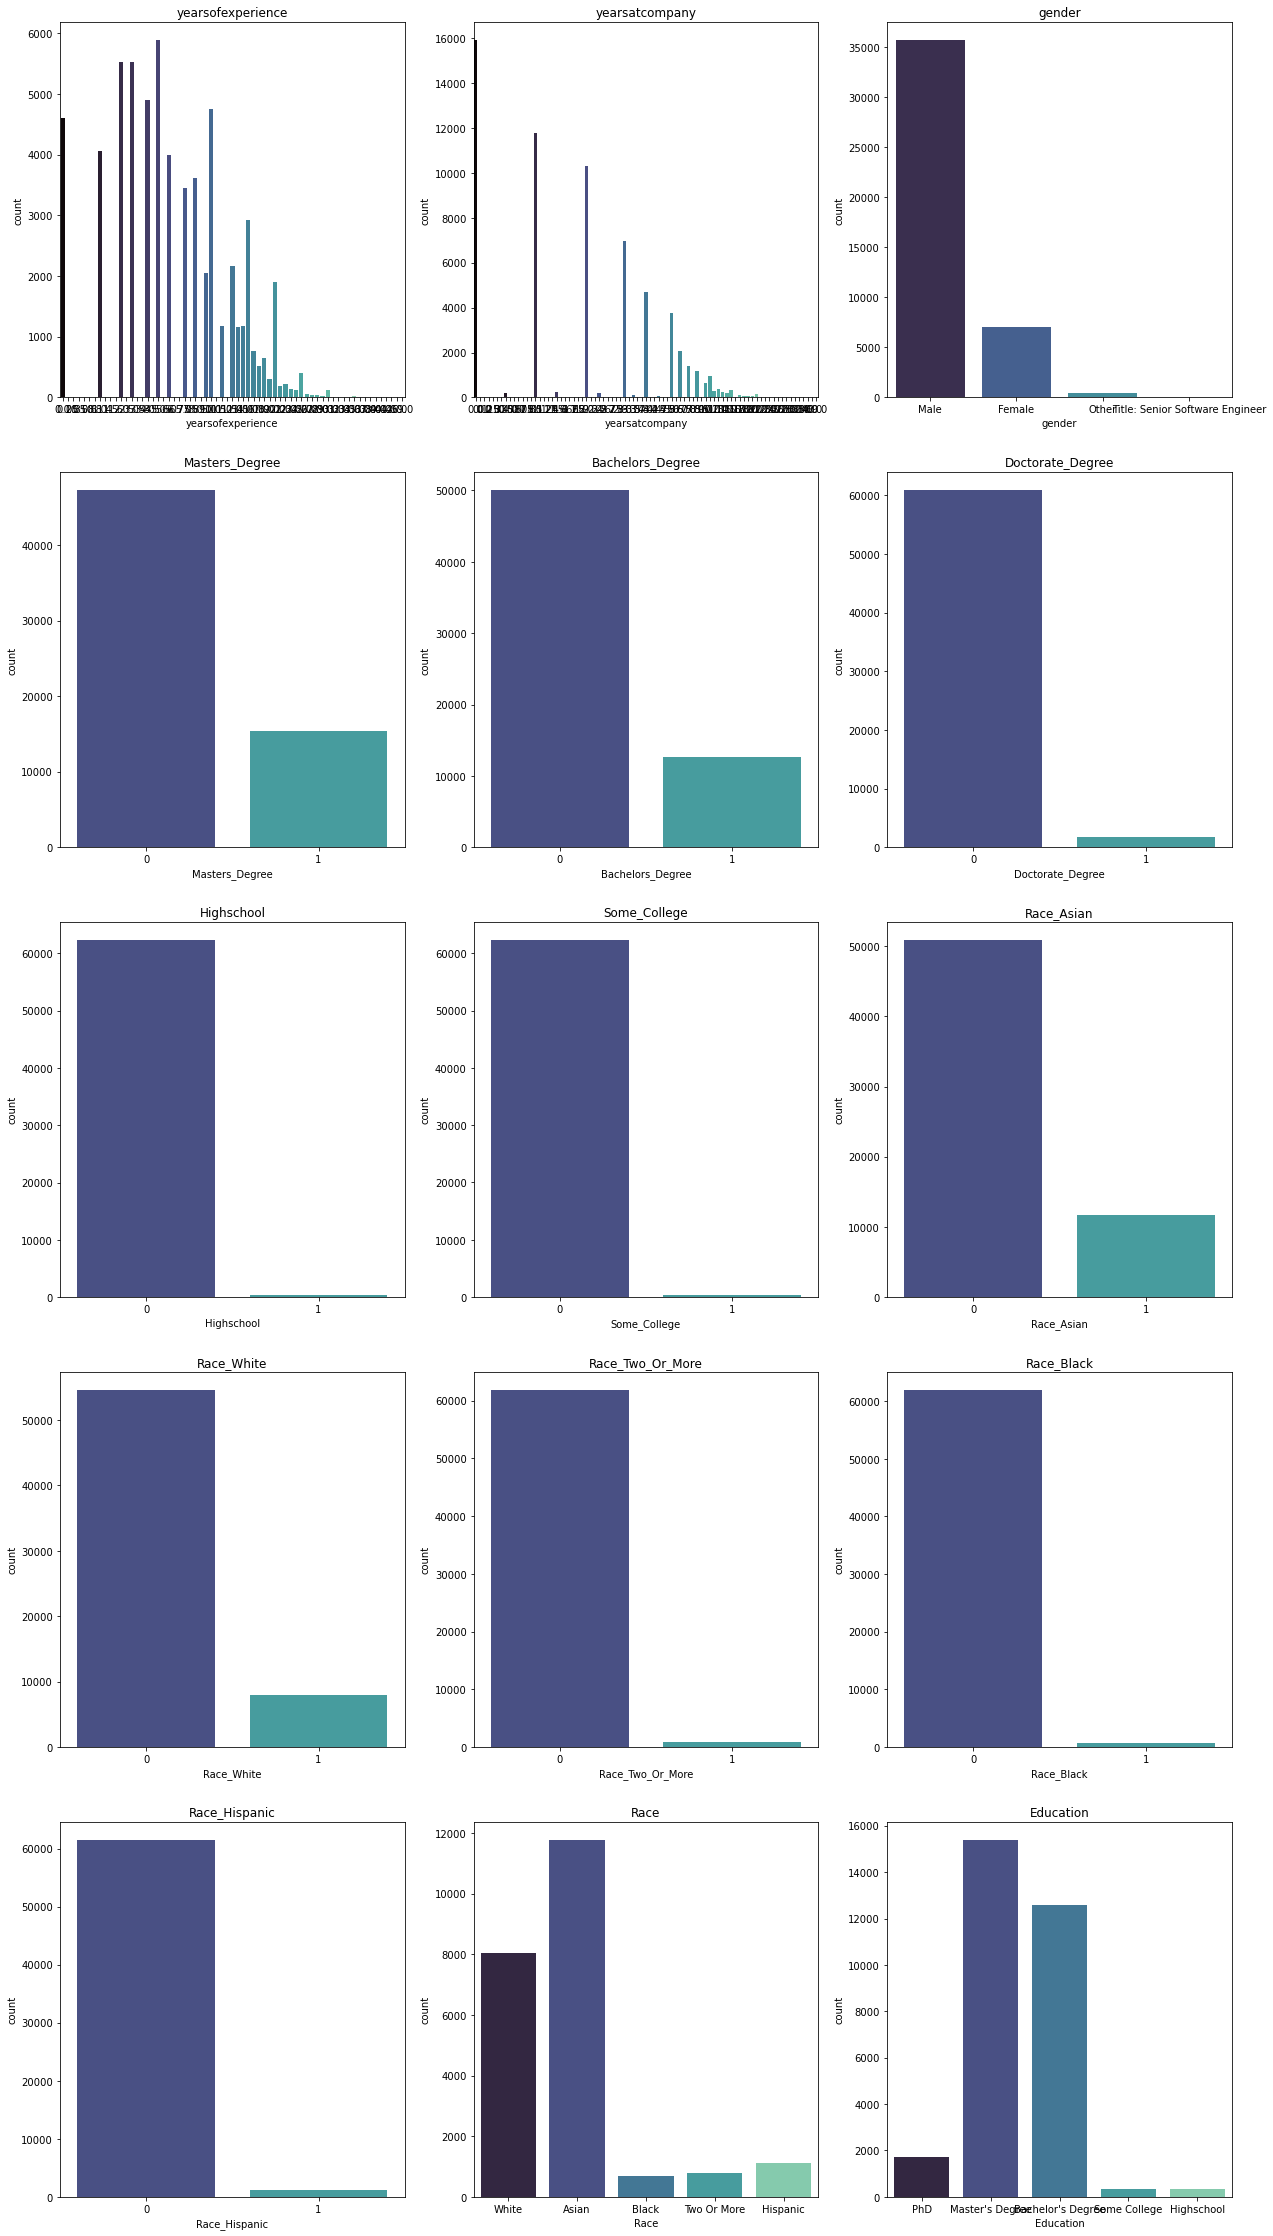

In [58]:
categorical_features = ['yearsofexperience', 'yearsatcompany', 'gender', 'Masters_Degree', 'Bachelors_Degree', 
                        'Doctorate_Degree', 'Highschool', 'Some_College', 'Race_Asian', 'Race_White', 'Race_Two_Or_More', 
                        'Race_Black', 'Race_Hispanic', 'Race', 'Education']

plot_features(df, categorical_features, is_categorical=True)

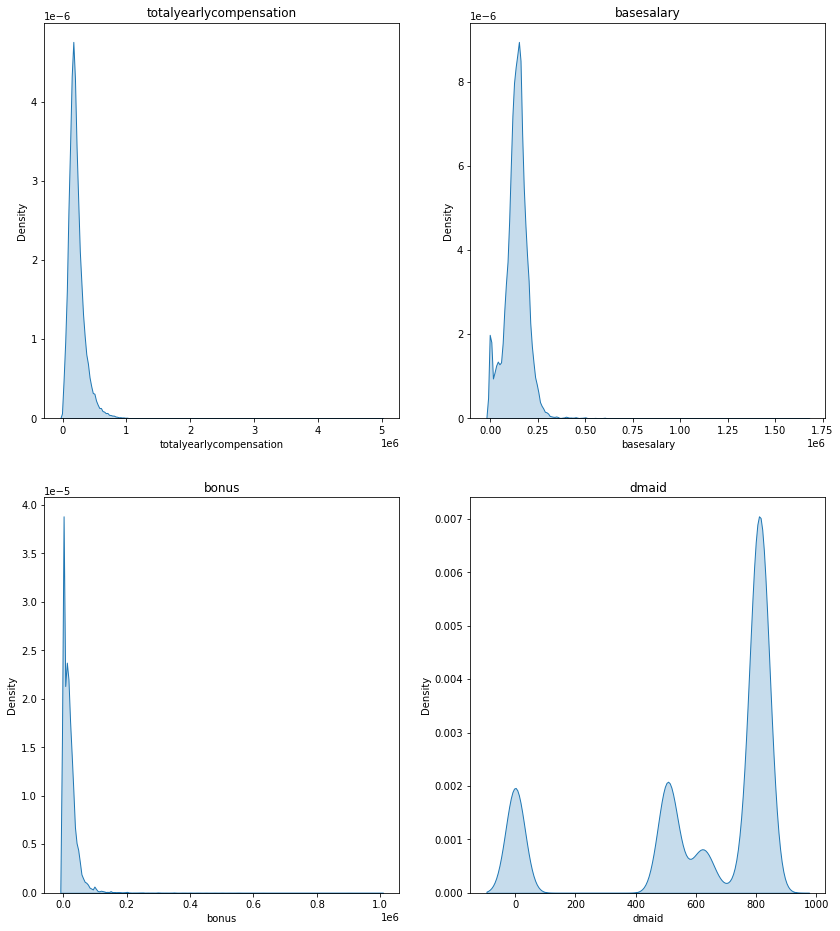

In [56]:
continuous_features = ['totalyearlycompensation', 'basesalary', 'bonus', 'dmaid']

plot_features(df, continuous_features, is_categorical=False)

In [57]:
#Skipped: timestamp, otherdetails, cityid, rowNumber

### Hypothesis Testing

#### Data Cleaning (Hypothesis)

In [367]:
df = raw_df[['company', 'title', 'totalyearlycompensation', 'location', 'yearsofexperience', 'yearsatcompany', 
             'gender', 'Education', 'Race', 'sector']]

In [375]:
# Rounds the number of years of experience (reduces number of categories)
df.loc[:,'yearsofexperience'] = np.round(df.loc[:,'yearsofexperience'])
df.loc[:,'yearsatcompany'] = np.round(df.loc[:,'yearsatcompany'])

#Drop users that had a higher value for yearsatcompany than yearsofexperience
df.drop(df[(df.loc[:,'yearsatcompany'] - df.loc[:,'yearsofexperience']) > 0].index.to_list(), inplace=True)

#Add region
df = extract_state(df)

#### Hypothesis 1 (When controlling for experience, do people with high vs. low experience years at current company make more?)

$H_0$: People that have worked longer in a company earn equal salaries than people that have not worked as long in that same company.

$H_1$: People that have worked longer in a company earn significantly different salaries than people that have not worked as long in that same company.<br>

*Controlling for 10 to 15 years of experience*

In [24]:
test_input1 = hypothesis_data1(df, 'yearsofexperience', 'yearsatcompany', 'totalyearlycompensation', [5, 10, 15])

In [31]:
for key in test_input1.keys():
    test = mannwhitneyu(test_input1[key][0], test_input1[key][1], alternative='two-sided') #Runs a Mann Whitney U-test
    if test.pvalue < 0.05:
        print('{} years of experience: \nWe reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))
    else:
        print('{} years of experience: \nWe fail to reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))

0-5 years of experience: 
We reject the Null Hypothesis (p-value = 1.588639724629893e-06)

5-10 years of experience: 
We reject the Null Hypothesis (p-value = 4.018405254335355e-08)

10-15 years of experience: 
We reject the Null Hypothesis (p-value = 1.6488392594767118e-06)

15-69.0 years of experience: 
We reject the Null Hypothesis (p-value = 4.798170853598533e-13)



In [42]:
for key in test_input1.keys():
    print('{} years of experience: \nlow experience: ${}, high experience: ${}\n'.format(key, int(test_input1[key][0].mean()), int(test_input1[key][1].mean())))

0-5 years of experience: 
low experience: $155618, high experience: $163693

5-10 years of experience: 
low experience: $218884, high experience: $213450

10-15 years of experience: 
low experience: $269486, high experience: $258579

15-69.0 years of experience: 
low experience: $334904, high experience: $312521



During the first 5 years at a company, it appears that people who have not worked at their current company for as long earn less, and that this difference in pay is statistically significant. However, for more experienced respondents, those who have spent less time at their current company make MORE, with this difference in medians also being significant. 

#### Hypothesis 2 (When controlling for experience, do people that work at FAANG earn higher salaries than people that don't?)

$H_0$: People that work at FAANG earn the same salary than other non-FAANG tech workers. <br>
$H_1$: People that work at FAANG earn a significantly different salary than other non-FAANG tech workers.<br>
*Controlling for 10 to 15 years of experience*

In [20]:
test_input2 = hypothesis_data2(df, 'yearsofexperience', 'sector', 'company', 'totalyearlycompensation', [5, 10, 15])

In [34]:
for key in test_input2.keys():
    test = mannwhitneyu(test_input2[key][0], test_input2[key][1], alternative='two-sided') #Runs a Mann Whitney U-test
    if test.pvalue < 0.05:
        print('{} years of experience: \nWe reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))
    else:
        print('{} years of experience: \nWe fail to reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))

0-5 years of experience: 
We reject the Null Hypothesis (p-value = 2.9692204779651074e-288)

5-10 years of experience: 
We reject the Null Hypothesis (p-value = 2.7851737643864135e-249)

10-15 years of experience: 
We reject the Null Hypothesis (p-value = 2.0603956403294878e-147)

15-69.0 years of experience: 
We reject the Null Hypothesis (p-value = 1.1132860793429578e-104)



In [40]:
for key in test_input2.keys():
    print('{} years of experience: \nfaang: ${}, non-faang: ${}\n'.format(key, int(test_input2[key][0].mean()), int(test_input2[key][1].mean())))

0-5 years of experience: 
faang: $225743, non-faang: $155794

5-10 years of experience: 
faang: $310869, non-faang: $200313

10-15 years of experience: 
faang: $387651, non-faang: $243107

15-69.0 years of experience: 
faang: $493835, non-faang: $302743



At all experience levels, FAANG respondents mae more than their non-Faang tech counterparts, with this difference being significant at all levels of experience. 

#### Hypothesis 3 (When controlling for experience, do men and women earn significantly different pay?)

$H_0$: The salaries of men and women are not statistically different. <br>
$H_1$: The salaries of men and women are statistically different. .<br>
*Controlling for years of experience

In [70]:
test_input3 = hypothesis_data3(df, [5, 10, 15])

In [71]:
for key in test_input3.keys():
    test = mannwhitneyu(test_input3[key][0], test_input3[key][1], alternative='two-sided') #Runs a Mann Whitney U-test
    if test.pvalue < 0.05:
        print('{} years of experience: \nWe reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))
    else:
        print('{} years of experience: \nWe fail to reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))

5 years of experience: 
We fail to reject the Null Hypothesis (p-value = 0.08140143716732828)

10 years of experience: 
We fail to reject the Null Hypothesis (p-value = 0.10355244621227366)

15 years of experience: 
We reject the Null Hypothesis (p-value = 1.4362411049763289e-06)



In [72]:
for key in test_input3.keys():
    print('{} years of experience: \nFemale: ${}, Male: ${}\n'.format(key, int(pd.Series(test_input3[key][0]).mean()), int(pd.Series(test_input3[key][1]).mean())))

5 years of experience: 
Female: $164150, Male: $163498

10 years of experience: 
Female: $180852, Male: $186980

15 years of experience: 
Female: $188779, Male: $200270



Given these results, we fail to reject the null hypothesis for respondents with 0-5 years of experience and 5-10 years of experience. However, total compensation for respondents with greater than 15 years of experience differs between women and men, with this difference being statistically significant.

#### Hypothesis 4 (When controlling for experience, do people with different education levels earn significally different salaries?)

$H_0$: People with different education levels do not earn statistically different salaries. <br>
$H_1$: People with different education levels earn statistically different salaries.<br>
*Controlling for years of experience

In [29]:
test_input4 = hypothesis_data4(df, [5, 10, 15])

In [62]:
combos = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
names = ['high school', 'bachelors', 'masters', 'Phd']

for key in test_input4.keys():
    for combo in combos:
    
        test = mannwhitneyu(test_input4[key][combo[0]], test_input4[key][combo[1]], alternative='two-sided') #Runs a Mann Whitney U-test
        #if test.pvalue < 0.05:
            #print('{} years of experience: ({}-{}) \nWe reject the Null Hypothesis (p-value = {})  {} {}\n'.format(key, names[combo[0]], names[combo[1]], test.pvalue, round(np.mean(test_input4[key][combo[0]])), round(np.mean(test_input4[key][combo[1]]))))
        #else:
            #print('{} years of experience: ({}-{})\nWe fail to reject the Null Hypothesis (p-value = {}) {} {}\n'.format(key, names[combo[0]], names[combo[1]], test.pvalue, np.mean(test_input4[key][combo[0]]), round(np.mean(test_input4[key][combo[1]]))))

$$
\begin{aligned}
& \text {P-values for Education levels (0-5 years of experience)}\\
&\begin{array}{cccc}
\hline \hline \text {} & \text { Highschool } & \text { Bachelor's} & \text {Master's} & \text {PhD} \\
\hline \text{Highschool} &  & 0.2 & 5.8e^{-10} & 1.2e^{-23}\\
\text{Bachelor's} & 0.2 &  & 3.4e^{-144} & 9.4e^{-161}\\
\text{Master's} & 5.8e^{-10} & 3.4e^{-144} &  \\
\text{PhD} & 1.2e^{-23} & 9.4e^{-161} & 1.7e^{-180} \\
\hline
\end{array}
\end{aligned}
$$

<font color='red'>Given these results, we fail to reject the null hypothesis for respondents with 0-5 years of experience and 5-10 years of experience. However, total compensation for respondents with greater than 15 years of experience differs between women and men, with this difference being statistically significant.<font>

#### Hypothesis 5 (When controlling for experience, do people living in different regions have significantly different salaries?)

$H_0$: People living in different regions do not earn statistically different salaries. <br>
$H_1$: People living in different regions earn statistically different salaries.<br>
*Controlling for years of experience

In [275]:
test_input5 = hypothesis_data5(df, [5, 10, 15])

In [277]:
for key in test_input5.keys(): 
    value_1 = test_input5[key]
    for key2 in test_input5.keys():
        value_2 = test_input5[key2]
        if (key[0] != key2[0]) & (key[1] == key2[1]):
            test = mannwhitneyu(test_input5[key], test_input5[key2], alternative='two-sided') 
            #if test.pvalue < 0.001:
                #print('Comparing {} with {}: We reject the Null Hypothesis (p-value = {})'.format(key, key2 ,test.pvalue))
            #else: 
                #print('Comparing {} with {}: We fail to reject the Null Hypothesis (p-value = {})'.format(key,key2, test.pvalue))

### Preprocessing

#### One-Hot encoding + Standardize

In [377]:
df[['company', 'title', 'totalyearlycompensation', 'location', 'yearsofexperience', 'yearsatcompany', 
             'gender', 'Education', 'Race', 'sector', 'region']].dropna(inplace=True)

In [378]:
# Salary prediction
features_salary = df[['title', 'gender', 'Education', 'Race', 'sector', 'yearsofexperience', 'yearsatcompany', 'region']]
target_salary = df['totalyearlycompensation']

In [379]:
onehot_df_salary = features_salary[['yearsofexperience', 'yearsatcompany']].copy()

scaler = StandardScaler()
target_salary = pd.DataFrame(scaler.fit_transform(target_salary.array.reshape(-1,1)), columns=['totalyearlycompensation'])
onehot_df_salary = pd.DataFrame(scaler.fit_transform(onehot_df_salary), columns = onehot_df_salary.columns)

cat_features = ['title', 'gender', 'Education', 'Race', 'sector', 'region']
for column in cat_features: 
    onehot_df_salary = pd.concat([onehot_df_salary, pd.get_dummies(features_salary[column].reset_index(drop=True), drop_first=True)], axis=1)

In [380]:
kf = KFold(n_splits=10, shuffle=True, random_state=101)
kf.get_n_splits(onehot_df_salary)

train_error, test_error, R_squared = [], [], []

for train_index, test_index in kf.split(onehot_df_salary):
    X_train, X_test = onehot_df_salary.iloc[train_index], onehot_df_salary.iloc[test_index]
    y_train, y_test = target_salary.iloc[train_index], target_salary.iloc[test_index]
    
    linreg = LinearRegression().fit(X_train, y_train)
    
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test) 
    
    train_error.append(mean_squared_error(y_train, y_train_pred))
    test_error.append(mean_squared_error(y_test, y_test_pred))
    R_squared.append(linreg.score(X_test, y_test))

print('Training MSE for this Linear Regression model: {}'.format(round(np.mean(train_error), 3)))
print('Testing MSE for this Linear Regression model: {}\n'.format(round(np.mean(test_error), 3)))
print('R^2: {}\n'.format(round(np.mean(R_squared), 3)))
    

Training MSE for this Linear Regression model: 0.653
Testing MSE for this Linear Regression model: 0.657

R^2: 0.362



In [388]:
linreg.coeffs_

AttributeError: 'LinearRegression' object has no attribute 'coefs_'

In [353]:
kf = KFold(n_splits=10, shuffle=True, random_state=101)
kf.get_n_splits(onehot_df_salary)

train_error, test_error, R_squared = [], [], []

for train_index, test_index in kf.split(onehot_df_salary):
    X_train, X_test = onehot_df_salary.iloc[train_index], onehot_df_salary.iloc[test_index]
    y_train, y_test = target_salary.iloc[train_index], target_salary.iloc[test_index]
    
    clf_xgb = xgb.XGBRegressor(random_state=101).fit(X_train, y_train)
    
    y_train_pred = clf_xgb.predict(X_train)
    y_test_pred = clf_xgb.predict(X_test) 
    
    train_error.append(mean_squared_error(y_train, y_train_pred))
    test_error.append(mean_squared_error(y_test, y_test_pred))
    R_squared.append(clf_xgb.score(X_test, y_test))

print('Training MSE for this XGBoost Regression model: {}'.format(round(np.mean(train_error), 3)))
print('Testing MSE for this Linear Regression model: {}\n'.format(round(np.mean(test_error), 3)))  
print('R^2: {}\n'.format(round(np.mean(R_squared), 3)))

Training MSE for this XGBoost Regression model: 0.32
Testing MSE for this Linear Regression model: 0.68

R^2: 0.326



## PCA

In [297]:
pca_df = df[['company', 'title', 'totalyearlycompensation', 'location',
             'yearsofexperience', 'yearsatcompany', 'gender', 'Education', 'Race', 'sector']]

In [298]:
pca_df.dropna(inplace=True)

In [299]:
company_cumsum = pd.DataFrame(df['company'].value_counts(normalize=True).cumsum()).reset_index()
company_cumsum.columns = ['company', 'cumsum']

top_companies = company_cumsum[company_cumsum['cumsum'] < 0.7]['company'].to_list()

pca_df.loc[~pca_df['company'].isin(top_companies), 'company'] = 'Other'

In [329]:
output_pca, vals, vecs = pca(normalized_df, var=.8)

### Forward Selection

In [381]:
ForwardSelection(onehot_df_salary, target_salary.to_numpy()[:,0])

Chosen feature: yearsofexperience (with SSE: 2783 and p-value: 0.0)
Chosen feature: West (with SSE: 3624 and p-value: 0.0)
Chosen feature: Technology (with SSE: 3919 and p-value: 0.0)
Chosen feature: Software Engineering Manager (with SSE: 4208 and p-value: 0.0)
Chosen feature: PhD (with SSE: 4402 and p-value: 0.0)
Chosen feature: Northeast (with SSE: 4579 and p-value: 0.0)
Chosen feature: yearsatcompany (with SSE: 4672 and p-value: 0.95549)
Chosen feature: Software Engineer (with SSE: 4756 and p-value: 0.70083)
Chosen feature: Product Manager (with SSE: 4884 and p-value: 0.69531)
Chosen feature: Media (with SSE: 4961 and p-value: 0.66861)
Chosen feature: Transportation (with SSE: 4994 and p-value: 0.48945)
Chosen feature: Male (with SSE: 5025 and p-value: 0.38313)
Chosen feature: Data Scientist (with SSE: 5047 and p-value: 0.42809)
Chosen feature: Product Designer (with SSE: 5067 and p-value: 0.41287)
Chosen feature: Management Consultant (with SSE: 5087 and p-value: 0.42764)
Chosen f

['yearsofexperience',
 'West',
 'Technology',
 'Software Engineering Manager',
 'PhD',
 'Northeast',
 'yearsatcompany',
 'Software Engineer',
 'Product Manager',
 'Media',
 'Transportation',
 'Male',
 'Data Scientist',
 'Product Designer',
 'Management Consultant',
 'Aerospace & Defense',
 'Recruiter',
 'Financials',
 "Master's Degree",
 'Retailing',
 'Sales',
 'Some College',
 'Food & Drug Stores',
 'Hispanic',
 'Other']

In [343]:
onehot_df_salary

array([ 1.40845769, -0.52179111,  0.94783013, ..., 31.38580641,
       15.82683127, 34.89534967])

In [386]:
plt.figure(figsize=(25,25))

corr = np.corrcoef(onehot_df_salary)
sns.heatmap(corr)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002C0993B25E0> (for post_execute):


KeyboardInterrupt: 

In [374]:
raw_df['region'].value_counts()

West         37103
Northeast     7880
South         6288
Midwest       2202
Name: region, dtype: int64